<a href="https://colab.research.google.com/github/simonbustamante/genoma-pca-and-k-means/blob/master/Caso_de_estudio_1_2_An%C3%A1lisis_de_la_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso de estudio 1.2: Análisis de la LDA (*Latent Dirichlet Allocation*)

Librerías a importar:

In [1]:
import sys, re, time, string, random, csv, argparse
import requests
import numpy as n
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import psi

#Librerías de web scraping
from bs4 import BeautifulSoup

from tqdm.notebook import tqdm

#Librerías de NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize


print('\n¡Librerías importadas con éxito!')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



¡Librerías importadas con éxito!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Generación de la base de datos (*Web Scraping*)

En primer lugar debemos obtener la lista de profesores del departamento de EECS, y el lab al que pertenecen. Para ello podemos usar librerías de _Web scraping_ como `BeautifulSoup`. Este tipo de librerías ofrecen funciones para explorar el código fuente de páginas web, y obtener información de su contenido.

In [2]:
url_eecs_fac = 'https://www.eecs.mit.edu/role/faculty/'
h = {"user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.4 Safari/605.1.15"}
html_data = requests.get(url_eecs_fac, headers=h).text
soup = BeautifulSoup(html_data, 'html.parser')

#Guardando el nombre y el laboratorio en dos listas
fac = []
labs = []
entries = soup.find_all('div', class_='people-entry')
for entry in entries:
    name = entry.find('h5').find('a').text.strip()
    lab = entry.find('div', class_='people-research').find_all('a')
    lab_names = [a.text for a in lab]
    fac.append(name)
    labs.append(lab_names)
fac_dept = list(zip(fac, labs))
fac_dept = [(tup[0], ', '.join(tup[1])) for tup in fac_dept if tup[1]]


print('Número de profesores de EECS: {}'.format(len(fac_dept)))
print(fac_dept[:5],'...')

Número de profesores de EECS: 177
[('Hal Abelson', 'AI and Society, Artificial Intelligence + Decision making, Artificial Intelligence + Machine Learning'), ('Elfar Adalsteinsson', 'AI for Healthcare and Life Sciences, Biological and Medical Devices and Systems, Graphics and Vision'), ('Fadel Adib', 'Systems and Networking'), ('Anant Agarwal', 'Computer Architecture, Multicore Processors & Cloud Computing, Programming Languages and Software Engineering'), ('Pulkit Agrawal', 'Artificial Intelligence + Machine Learning, Graphics and Vision, Human-Computer Interaction')] ...


In [3]:
html_data = requests.get(url_eecs_fac).text
html_data
soup = BeautifulSoup(html_data, 'html.parser')


Definimos una función para obtener todos los artículos de _arXiv_ de un autor determinado.

In [11]:
def get_articles_for_author(author):
    base_url = 'https://arxiv.org/search/?query=%22{name}%22&searchtype=author&abstracts=show&order=-announced_date_first&size=200'
    author_query_url = base_url.format(name= author.replace(' ','+'))
    query_result = requests.get(author_query_url).text
    soup = BeautifulSoup(query_result, 'html.parser')
    articles = soup.find_all(class_ = 'arxiv-result')

    ids = [el.find(class_ = 'list-title is-inline-block').find('a').text.strip('arXiv:') for el in articles]
    ids = [el.split('/')[1] if el.find('/')>=0 else el for el in ids]

    titles = [el.find(class_ = 'title is-5 mathjax').text.strip(' \n') for el in articles]
    authors = [[author.text for author in el.find(class_ = 'authors').find_all('a')] for el in articles]
    abstracts = []
    for el in articles:
        try:
            abstracts.append(el.find(class_ = 'abstract-full has-text-grey-dark mathjax').text[9:-16])
        except:
            abstracts.append(el.find(class_ = 'abstract-short has-text-grey-dark mathjax').text[9:-16])
    urls = [el.find(class_ = 'list-title is-inline-block').find('a')['href'] for el in articles]

    return ids, titles, authors, urls, abstracts

author = fac_dept[24][0]
print('Ejemplo de un artículo de {}: \n'.format(author))
ids, titles, authors, urls, abstracts = get_articles_for_author(author)
i = 0
print('arXiv ID: {} (url: {} )'.format(ids[i],urls[i]))
print('Título: {}'.format(titles[i]))
print('Autores: {}'.format(authors[i]))
print('---\n{}\n---'.format(abstracts[i]))

Ejemplo de un artículo de Tamara Broderick: 

arXiv ID: 2402.03527 (url: https://arxiv.org/abs/2402.03527 )
Título: Consistent Validation for Predictive Methods in Spatial Settings
Autores: ['David R. Burt', 'Yunyi Shen', 'Tamara Broderick']
---
Spatial prediction tasks are key to weather forecasting, studying air pollution, and other scientific endeavors. Determining how much to trust predictions made by statistical or physical methods is essential for the credibility of scientific conclusions. Unfortunately, classical approaches for validation fail to handle mismatch between locations available for validation and (test) locations where we want to make predictions. This mismatch is often not an instance of covariate shift (as commonly formalized) because the validation and test locations are fixed (e.g., on a grid or at select points) rather than i.i.d. from two distributions. In the present work, we formalize a check on validation methods: that they become arbitrarily accurate as val

Una vez tenemos dicha función definida y hemos comprobado que funciona, podemos iterar la lista de profesores para obtener los artículos de cada profesor.

In [12]:
ids = []
titles = []
authors = []
labs = []
EECS_facs = []
urls = []
abstracts = []
print('Descargando artículos de cada profesor:')
t0 = time.time()
for i,fac in enumerate(fac_dept):
    id_list, title_list, author_list, url_list, abstract_list  = get_articles_for_author(fac[0])
    ids += id_list
    titles += title_list
    authors += author_list
    urls += url_list
    abstracts += abstract_list
    labs += [fac[1]]*len(id_list)
    EECS_facs += [fac[0]]*len(id_list)
    if round(i/10) == i/10:
        print('{}/{} autores'.format(i,len(fac_dept)))
tf = time.time()
print('{} artículos descargados en {:.2f}s'.format(len(ids),tf-t0))

Descargando artículos de cada profesor:
0/177 autores
10/177 autores
20/177 autores
30/177 autores
40/177 autores
50/177 autores
60/177 autores
70/177 autores
80/177 autores
90/177 autores
100/177 autores
110/177 autores
120/177 autores
130/177 autores
140/177 autores
150/177 autores
160/177 autores
170/177 autores
5348 artículos descargados en 87.54s


Podemos guardar toda la información en una tabla de `pandas`, la siguiente celda muestra cómo hacerlo:

In [13]:
df = pd.DataFrame({'id':ids,'title':titles,'EECS_prof':EECS_facs,'lab':labs,'authors':authors,'url':urls,'abstract':abstracts})
df[['id','lab']] = df[['id','lab']].drop_duplicates()
df.head()

,id,title,EECS_prof,lab,authors,url,abstract
0,2312.04839,Understanding Teacher Perspectives and Experie...,Hal Abelson,"AI and Society, Artificial Intelligence + Deci...","[Prerna Ravi, Annalisa Broski, Glenda Stump, H...",https://arxiv.org/abs/2312.04839,Artificial Intelligence (AI) and its associate...
1,2212.04629,Post hoc Explanations may be Ineffective for D...,Hal Abelson,"AI and Society, Artificial Intelligence + Deci...","[Julius Adebayo, Michael Muelly, Hal Abelson, ...",https://arxiv.org/abs/2212.04629,We investigate whether three types of post hoc...
2,2110.07450,Bugs in our Pockets: The Risks of Client-Side ...,Hal Abelson,"AI and Society, Artificial Intelligence + Deci...","[Hal Abelson, Ross Anderson, Steven M. Bellovi...",https://arxiv.org/abs/2110.07450,Our increasing reliance on digital technology ...
3,2303.02254,Zero-Shot Self-Supervised Joint Temporal Image...,Elfar Adalsteinsson,"AI for Healthcare and Life Sciences, Biologica...","[Molin Zhang, Junshen Xu, Yamin Arefeen, Elfar...",https://arxiv.org/abs/2303.02254,Fast spin-echo (FSE) pulse sequences for Magne...
4,2301.10365,Data Consistent Deep Rigid MRI Motion Correction,Elfar Adalsteinsson,"AI for Healthcare and Life Sciences, Biologica...","[Nalini M. Singh, Neel Dey, Malte Hoffmann, Br...",https://arxiv.org/abs/2301.10365,Motion artifacts are a pervasive problem in MR...


## Obtención del vocabulario

Para poder utilizar las funciones proporcionadas en el guión del caso de estudio se necesita un archivo de vocabulario en formato `.csv`. Podemos obtenerlo del repositorio del estudio original de LDA SVI:

In [14]:
url = 'https://raw.githubusercontent.com/blei-lab/onlineldavb/master/dictnostops.txt'
vocab_list = pd.Series(requests.get(url).text.split('\n')[:-1])
vocab = {}
for index, word in enumerate(vocab_list):
    vocab[word] = index
vocab_list

0         writings
1           yellow
2             four
3            woods
4          hanging
           ...    
7697       upwards
7698         ranks
7699    indirectly
7700       volumes
7701        allein
Length: 7702, dtype: object

# LDA-SVI

## Funciones auxiliares

### Generación de atributos de cada texto (recuento de palabras)

In [36]:
def parseDocument(doc, vocab):
    wordslist = list()
    countslist = list()
    doc = doc.lower()
    tokens = wordpunct_tokenize(doc)

    dictionary = dict()
    for word in tokens:
        if word in vocab:
            wordtk = vocab[word]
            if wordtk not in dictionary:
                dictionary[wordtk] = 1
            else:
                dictionary[wordtk] += 1

    wordslist.append(list(dictionary.keys()))
    countslist.append(list(dictionary.values()))
    return (wordslist[0], countslist[0])

### Cálculo de distribuciones de probabilidad

In [38]:
def dirichlet_expectation(alpha):
    '''
    For a vector theta ~ Dir(alpha), computes E[log(theta)] given alpha.

    Taken from https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py
    '''
    if (len(alpha.shape) == 1):
        return (psi(alpha) - psi(n.sum(alpha)))
    return (psi(alpha) - psi(n.sum(alpha, 1))[:, n.newaxis])

def beta_expectation(a, b, k):
    mysum = psi(a + b)
    Elog_a = psi(a) - mysum
    Elog_b = psi(b) - mysum
    Elog_beta = n.zeros(k)
    Elog_beta[0] = Elog_a[0]
    # print Elog_beta
    for i in range(1, k):
        Elog_beta[i] = Elog_a[i] + n.sum(Elog_b[0:i])
        # print Elog_beta
    # print Elog_beta
    return Elog_beta

def plottrace(x, Y, K, n, perp):
    for i in range(K):
        plt.plot(x, Y[i], label = "Topic %i" %(i+1))

    plt.xlabel("Number of Iterations")
    plt.ylabel("Probability of Each topic")
    plt.legend()
    plt.title("Trace plot for topic probabilities")
    plt.savefig("temp/plot_%i_%i_%f.png" %(K, n, perp))

## Implementación de la LDA mediante SVI

Obtenemos la implementación de LDA mediante SVI de las fuentes mencionadas en el guión:
* https://github.com/qlai/stochasticLDA
* https://github.com/blei-lab/onlineldavb

In [40]:
n.random.seed(10000001)
meanchangethresh = 1e-3
MAXITER = 10000

class SVILDA():
    """
        Arguments:
        K: Number of topics
        vocab: A set of words to recognize. When analyzing documents, any word
           not in this set will be ignored.
        D: Total number of documents in the population. For a fixed corpus,
           this is the size of the corpus. In the truly online setting, this
           can be an estimate of the maximum number of documents that
           could ever be seen.
        alpha: Hyperparameter for prior on weight vectors theta
        eta: Hyperparameter for prior on topics beta
        tau: A (positive) learning parameter that downweights early iterations
        kappa: Learning rate: exponential decay rate---should be between
             (0.5, 1.0] to guarantee asymptotic convergence.
        Note that if you pass the same set of D documents in every time and
        set kappa=0 this class can also be used to do batch VB.
    """

    def __init__(self, vocab, K, D, alpha, eta, tau, kappa, docs, iterations, parsed = False):
        self._vocab = vocab
        self._V = len(vocab)
        self._K = K
        self._D = D
        self._alpha = alpha
        self._eta = eta
        self._tau = tau
        self._kappa = kappa
        self._lambda = 1* n.random.gamma(100., 1./100., (self._K, self._V))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)
        self._docs = docs
        self.ct = 0
        self._iterations = iterations
        self._parsed = parsed
        self._trace_lambda = {}
        for i in range(self._K):
            self._trace_lambda[i] = [self.computeProbabilities()[i]]
        self._x = [0]

    def updateLocal(self, doc): #word_dn is an indicator variable with dimension V
        (words, counts) = doc
        newdoc = []
        N_d = sum(counts)
        phi_d = n.zeros((self._K, N_d))
        gamma_d = n.random.gamma(100., 1./100., (self._K))
        Elogtheta_d = dirichlet_expectation(gamma_d)
        expElogtheta_d = n.exp(Elogtheta_d)
        for i, item in enumerate(counts):
            for j in range(item):
                newdoc.append(words[i])
        assert len(newdoc) == N_d, "error"

        for i in range(self._iterations):
            for m, word in enumerate(newdoc):
                phi_d[:, m] = n.multiply(expElogtheta_d, self._expElogbeta[:, word]) + 1e-100
                phi_d[:, m] = phi_d[:, m]/n.sum(phi_d[:, m])

            gamma_new = self._alpha + n.sum(phi_d, axis = 1)
            meanchange = n.mean(abs(gamma_d - gamma_new))
            if (meanchange < meanchangethresh):
                break

            gamma_d = gamma_new
            Elogtheta_d = dirichlet_expectation(gamma_d)
            expElogtheta_d = n.exp(Elogtheta_d)

        newdoc = n.asarray(newdoc)
        return phi_d, newdoc, gamma_d

    def updateGlobal(self, phi_d, doc):

        lambda_d = n.zeros((self._K, self._V))

        for k in range(self._K):
            phi_dk = n.zeros(self._V)
            for m, word in enumerate(doc):
                phi_dk[word] += phi_d[k][m]
            lambda_d[k] = self._eta + self._D * phi_dk
        rho = (self.ct + self._tau) **(-self._kappa)
        self._lambda = (1-rho) * self._lambda + rho * lambda_d
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)

        if self.ct % 10 == 9:
            for i in range(self._K):
                self._trace_lambda[i].append(self.computeProbabilities()[i])
            self._x.append(self.ct)

    def runSVI(self):
        for i in tqdm(range(self._iterations)):
            randint = random.randint(0, self._D-1)
            if self._parsed == False:
                doc = parseDocument(self._docs[randint],self._vocab)
            phi_doc, newdoc, gamma_d = self.updateLocal(doc)
            self.updateGlobal(phi_doc, newdoc)
            self.ct += 1

    def computeProbabilities(self):
        prob_topics = n.sum(self._lambda, axis = 1)
        prob_topics = prob_topics/n.sum(prob_topics)
        return prob_topics

    def getTopics(self, docs = None):
        prob_topics = self.computeProbabilities()
        prob_words = n.sum(self._lambda, axis = 0)

        if docs == None:
            docs = self._docs
        results = n.zeros((len(docs), self._K))
        for i, doc in enumerate(docs):
            parseddoc = parseDocument(doc, self._vocab)

            for j in range(self._K):
                aux = [self._lambda[j][word]/prob_words[word] for word in parseddoc[0]]
                doc_probability = [n.log(aux[k]) * parseddoc[1][k] for k in range(len(aux))]
                results[i][j] = sum(doc_probability) + n.log(prob_topics[j])
        finalresults = n.zeros(len(docs))
        for k in range(len(docs)):
            finalresults[k] = n.argmax(results[k])
        return finalresults, prob_topics

    def calcPerplexity(self, docs = None):
        perplexity = 0.
        doclen = 0.
        if docs == None:
            docs =  self._docs
        for doc in docs:
            parseddoc = parseDocument(doc, self._vocab)
            _, newdoc, gamma_d = self.updateLocal(parseddoc)
            approx_mixture = n.dot(gamma_d, self._lambda)
            # print(n.shape(approx_mixture))
            approx_mixture = approx_mixture / n.sum(approx_mixture)
            log_doc_prob = 0.
            for word in newdoc:
                log_doc_prob += n.log(approx_mixture[word])
            perplexity += log_doc_prob
            doclen += len(newdoc)
            # print(perplexity, doclen)
        perplexity = n.exp( - perplexity / doclen)
        print(perplexity)
        return perplexity

    def plotTopics(self, perp):
        plottrace(self._x, self._trace_lambda, self._K, self._iterations, perp)

def test(k, iterations):

    docs = getalldocs("alldocs2.txt")
    vocab = getVocab("dictionary2.csv")

    testset = SVILDA(vocab = vocab, K = k, D = len(docs), alpha = 0.2,
                     eta = 0.2, tau = 1024, kappa = 0.7, docs = docs,
                     iterations= iterations)
    testset.runSVI()
    finallambda = testset._lambda

    heldoutdocs = getalldocs("testdocs.txt")
    perplexity = testset.calcPerplexity(docs = heldoutdocs)

    with open("temp/%i_%i_%f_results.csv" %(k, iterations, perplexity), "w+") as f:
        writer = csv.writer(f)
        for i in range(k):
            bestwords = sorted(range(len(finallambda[i])), key=lambda j:finallambda[i, j])
            bestwords.reverse()
            writer.writerow([i])
            for j, word in enumerate(bestwords):
                writer.writerow([word, vocab.keys()[vocab.values().index(word)]])
                if j >= 15:
                    break
    topics, topic_probs = testset.getTopics()
    testset.plotTopics(perplexity)

    for kk in range(0, len(finallambda)):
        lambdak = list(finallambda[kk, :])
        lambdak = lambdak / sum(lambdak)
        temp = zip(lambdak, range(0, len(lambdak)))
        temp = sorted(temp, key = lambda x: x[0], reverse=True)
        # print temp
        print('topic %d:' % (kk))
        # feel free to change the "53" here to whatever fits your screen nicely.
        for i in range(0, 10):
            print('%20s  \t---\t  %.4f' % (vocab.keys()[vocab.values().index(temp[i][1])], temp[i][0]))

    with open("temp/%i_%i_%f_raw.txt" %(k, iterations, perplexity), "w+") as f:
        # f.write(finallambda)
        for result in topics:
            f.write(str(result) + " \n")
        f.write(str(topic_probs) + " \n")

# Resultados

Una vez definidas todas las funciones necesarias sólo queda ejecutar el análisis de LDA:

(este análisis le llevará unos 25 minutos... ¡tenga paciencia!)

In [41]:
# @title Texto de título predeterminado
mode = 'normal'
K = 5
alpha = 0.2
eta = 0.2
tau = 1024
kappa = 0.7
iterations = 100000

if mode == "test":
    test(K, iterations)
if mode == "normal":
    docs = df.abstract.to_list()
    D = len(docs)
    print('number of docs: {}'.format(D))
    lda = SVILDA(vocab = vocab, K = K, D = D, alpha = alpha,
                 eta = eta, tau = tau, kappa = kappa, docs = docs,
                 iterations = iterations)
    lda.runSVI()
    lda

number of docs: 5348


  0%|          | 0/100000 [00:00<?, ?it/s]

Podemos observar las distribución de probabilidades de cada palabra del vocabulario con respecto a cada tema identificado en los textos:

In [42]:
lambda_df = pd.DataFrame({'word':list(vocab.keys())})
for i in range(K):
    lambda_df['Topic {}'.format(i+1)] = lda._lambda[i,:]
lambda_df

,word,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,writings,0.200000,0.200000,0.200000,0.200000,0.200000
1,yellow,0.213092,0.202041,0.200824,0.204197,0.277442
2,four,73.332868,48.381631,20.657962,0.209019,0.207506
3,woods,0.200000,0.200000,0.200000,0.200000,0.200000
4,hanging,2.020162,0.210378,1.618652,0.201027,0.212223
...,...,...,...,...,...,...
7697,upwards,0.203882,0.838467,0.200012,0.200815,0.214535
7698,ranks,0.207932,0.201629,0.222830,10.568234,0.206480
7699,indirectly,0.204489,0.208020,6.370150,0.207068,0.201057
7700,volumes,0.205668,26.938803,0.203695,0.203368,0.208087


Para entender cómo el algoritmo de LDA ha calculado la distribución de probabilidades de cada tema podemos observar las 10 palabras con mayor probabilidad por tema:

In [ ]:
lambda_df.dtypes

In [44]:
finalresults, prob_topics = lda.getTopics()

for column,prob in list(zip(lambda_df.columns[1:],prob_topics)):
    print('{} probability: {:.2f}%'.format(column,prob*100))
    print(lambda_df.nlargest(10, [column])[['word',column]],'\n')

Topic 1 probability: 47.85%
             word      Topic 1
3524         data  3419.058292
2717     learning  2909.508417
6637        model  2814.987141
3590        based  2043.821720
4582  performance  1859.018391
2076      network  1786.172892
4605         show  1550.509609
982        method  1529.137745
6068     approach  1420.561679
1345      methods  1418.462729 

Topic 2 probability: 14.34%
         word      Topic 2
1646   system  1148.634240
1538     high   772.477970
3013  systems   749.090700
3443  control   734.300799
5015   energy   594.477791
229    object   458.509621
5293   single   457.574519
6799   design   382.639333
4831    field   366.508048
4909      two   355.150871 

Topic 3 probability: 22.47%
          word      Topic 3
493       time  1330.357621
1884   problem  1244.867775
2844       log  1162.389554
4605      show  1114.948856
1135    number   779.648297
1428   results   731.416015
7220  problems   726.158866
4308    bounds   717.468657
6843     known   654.7

Finalmente, también podemos observar cómo ha quedado la distribución de temas sobre el conjunto de los documentos descargados:

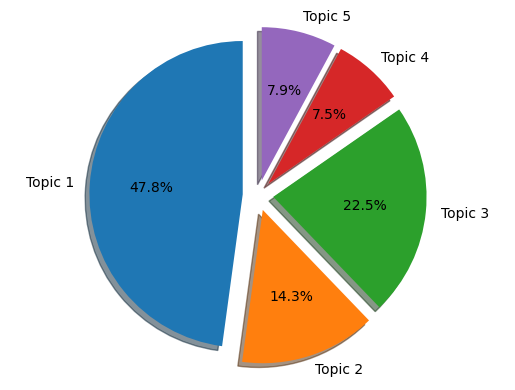

In [45]:
labels = lambda_df.columns[1:]
sizes = prob_topics*100
explode = (0.1, 0.1, 0.1,0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Tarea adicional

Intentar reproducir el Gráfico 2 del guión del Caso de estudio 1.2, donde se analiza qué temas predominan en cada laboratorio.

In [ ]:
# Código